# Urban Simulation Exercise 1

## **Author:** Noam Gal

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from random import choice, randint, shuffle, choices
from scipy.stats import linregress
from scipy.stats import f_oneway



# Part A

In [5]:
class Cell:
    def __init__(self, x, y): # inputs - coordinates
        self.x = x
        self.y = y
        
        self.agents = [] # stores agents located within the cell
        self.crimes = 0 # tracks the number of crimes committed in the cell


class Agent:
    def __init__(self, a_type, cell, budget):
        '''inputs:
            a_type (str): type of agent - resident/criminal,
            cell (Cell object): cell in which the agent starts the simulation
            budget (int): resources at the disposal of the agent
            '''
        self.a_type = a_type
        self.cell = cell
        self.budget = budget
        
        cell.agents.append(self) # locate agent inside the cell
    
    def resident_step(self):
        '''step method for resident agents - moves to a random new cell'''
        self.budget += 1 # resources increase with every step
        new_cell = self.cell # set current cell as new cell
        while new_cell == self.cell: # loop to make sure a new cell is selected
            new_cell = choice(choice(model.grid)) # randomly choose an array and a cell from the array
        return new_cell
        
    
    def criminal_step(self):
        '''step method for criminal agents - 
        move to a random cell, randomly select an agent and steal 1 resource point'''
        new_cell = self.cell # set current cell as new cell
        while new_cell == self.cell: # loop to make sure a new cell is selected
            new_cell = choice(choice(model.grid)) # randomly choose an array and a cell from the array
            
        if new_cell.agents: # if there are any agents in the cell (empty list==False)
            agent = choice(new_cell.agents) # randomly choose an agent present in the cell
            if agent.budget > 0: # if the agent has any resources - steal one unit
                agent.budget -= 1 # remove one unit of resources from selected agent
                self.budget += 1 # add one unit to current agent
                new_cell.crimes += 1 # increase the new cell's crime counter
    
        return new_cell
    
    def step(self):
        '''General step method for both types of agents:
            locates new cell and makes the required changes'''
        if self.a_type == 'resident': # check agent type and activate step method
            new_cell = self.resident_step()
        else:
            new_cell = self.criminal_step()
        
        self.cell.agents.remove(self) # remove current agent from current cell
        new_cell.agents.append(self) # add current agent to new cell
        self.cell = new_cell # move current agent to new cell
        

class Model:
    def __init__(self, residents_num, criminal_num, grid_shape):
        '''inputs: residents_num (int) - number of resident agents,
        criminal_num (int) - number of criminal agents,
        grid_shape (container of two int items) - number of grid rows and columns'''
        self.grid_shape = grid_shape
        
        # create a 2D array of Cell objects
        self.grid = [[Cell(x, y) for y in range(grid_shape[1])] for x in range(grid_shape[0])] 
        # create a 1d Array of Agent objects  (length==resident_num) located in a random cell and with a random budget
        self.residents = [Agent('resident', choice(choice(self.grid)), randint(10, 50)) for i in range(residents_num)]
        # create a 1d Array of Agent objects  (length==criminal_num) located in a random cell and with budget==1
        self.criminals = [Agent('criminal', choice(choice(self.grid)), 1) for i in range(criminal_num)]
    
    def simulate(self):
        '''Run 30 iterations and return the total number of crimes, maximal number of crimes per cell,
        and percent of cells where no crimes were registered througout the simulation'''
        for i in range(30):
            agents = self.residents + self.criminals # merge the lists of agents into one
            shuffle(agents) # randomly reorder the merged list
            for agent in agents: # execute step function per agent
                agent.step()
        
        # generate outputs - get the count of crimes per cell
        crimes = [self.grid[x][y].crimes for x in range(self.grid_shape[0]) for y in range(self.grid_shape[1])]
        total_crimes = sum(crimes) # total number of crimes committed throughout the simulation
        max_crimes = max(crimes) # get the counter value for the cell with the most crimes committed
        # compute the percent of cells where no crime was committed
        no_crimes = 100 * len([c for c in crimes if c==0]) / (self.grid_shape[0] * self.grid_shape[1])
        return(total_crimes, max_crimes, no_crimes)

In [6]:
# dataframe to save outputs
outputs_avg = pd.DataFrame(columns = {
    'Total crimes':[],
    'Maximum crimes':[],
    '% crime-free cells':[]
})

In [7]:
# loads model parameters for Part A
params = pd.read_csv("crime_model_parameters.csv")

# iterates through the parameters
for n, row in params.iterrows():
    total = []
    maximum = []
    percent = []
    # runs the simulation 5 times for each sets of parameters
    # saves averages of the 5 outputs
    for r in range(5):
        model = Model(row[0], row[1],(row[2], row[3]))
        results = model.simulate()
        total.append(results[0])
        maximum.append(results[1])
        percent.append(results[2])
    outputs_avg.loc[len(outputs_avg)] = [np.mean(total),np.mean(maximum),np.mean(percent)]

In [8]:
print(outputs_avg)

   Total crimes  Maximum crimes  % crime-free cells
0         516.2            10.8            0.200000
1         119.4             2.6           87.666667
2          39.8             1.8           98.448000
3        1034.8            19.6            0.000000
4         238.8             3.8           77.044444
5          89.0             2.2           96.560000
6        1552.0            27.2            0.000000
7         369.0             4.0           67.955556
8         131.2             2.2           95.096000


In [9]:
effects = pd.concat([params, outputs_avg], axis=1)

print(effects)
# saves output for table in writeup
#effects.to_csv('effects_A.csv')

   residents_num   criminal_num   grid_shape1  grid_shape2  Total crimes  \
0             180             20           10           10         516.2   
1             180             20           30           30         119.4   
2             180             20           50           50          39.8   
3             160             40           10           10        1034.8   
4             160             40           30           30         238.8   
5             160             40           50           50          89.0   
6             140             60           10           10        1552.0   
7             140             60           30           30         369.0   
8             140             60           50           50         131.2   

   Maximum crimes  % crime-free cells  
0            10.8            0.200000  
1             2.6           87.666667  
2             1.8           98.448000  
3            19.6            0.000000  
4             3.8           77.044444  

## EDA and Statistical Testing for Part A

In [11]:
# data cleaning for modeling

# Remove extra space from column names
effects.columns = effects.columns.str.strip()

# Combine the two grid_shape columns into a new column
effects['total_grid_shape'] = effects['grid_shape1'] + effects['grid_shape2']

# drop old grid shape columns 
effects.drop(columns=['grid_shape1', 'grid_shape2'], inplace=True)

print(effects.head())

   residents_num  criminal_num  Total crimes  Maximum crimes  \
0            180            20         516.2            10.8   
1            180            20         119.4             2.6   
2            180            20          39.8             1.8   
3            160            40        1034.8            19.6   
4            160            40         238.8             3.8   

   % crime-free cells  total_grid_shape  
0            0.200000                20  
1           87.666667                60  
2           98.448000               100  
3            0.000000                20  
4           77.044444                60  


In [12]:
# Define the input parameters and outcome variables
input_params = ['residents_num', 'criminal_num', 'total_grid_shape']
outcome_vars = ['Total crimes', 'Maximum crimes', '% crime-free cells']

# Print the first few rows of the DataFrame
print(effects.head())

   residents_num  criminal_num  Total crimes  Maximum crimes  \
0            180            20         516.2            10.8   
1            180            20         119.4             2.6   
2            180            20          39.8             1.8   
3            160            40        1034.8            19.6   
4            160            40         238.8             3.8   

   % crime-free cells  total_grid_shape  
0            0.200000                20  
1           87.666667                60  
2           98.448000               100  
3            0.000000                20  
4           77.044444                60  


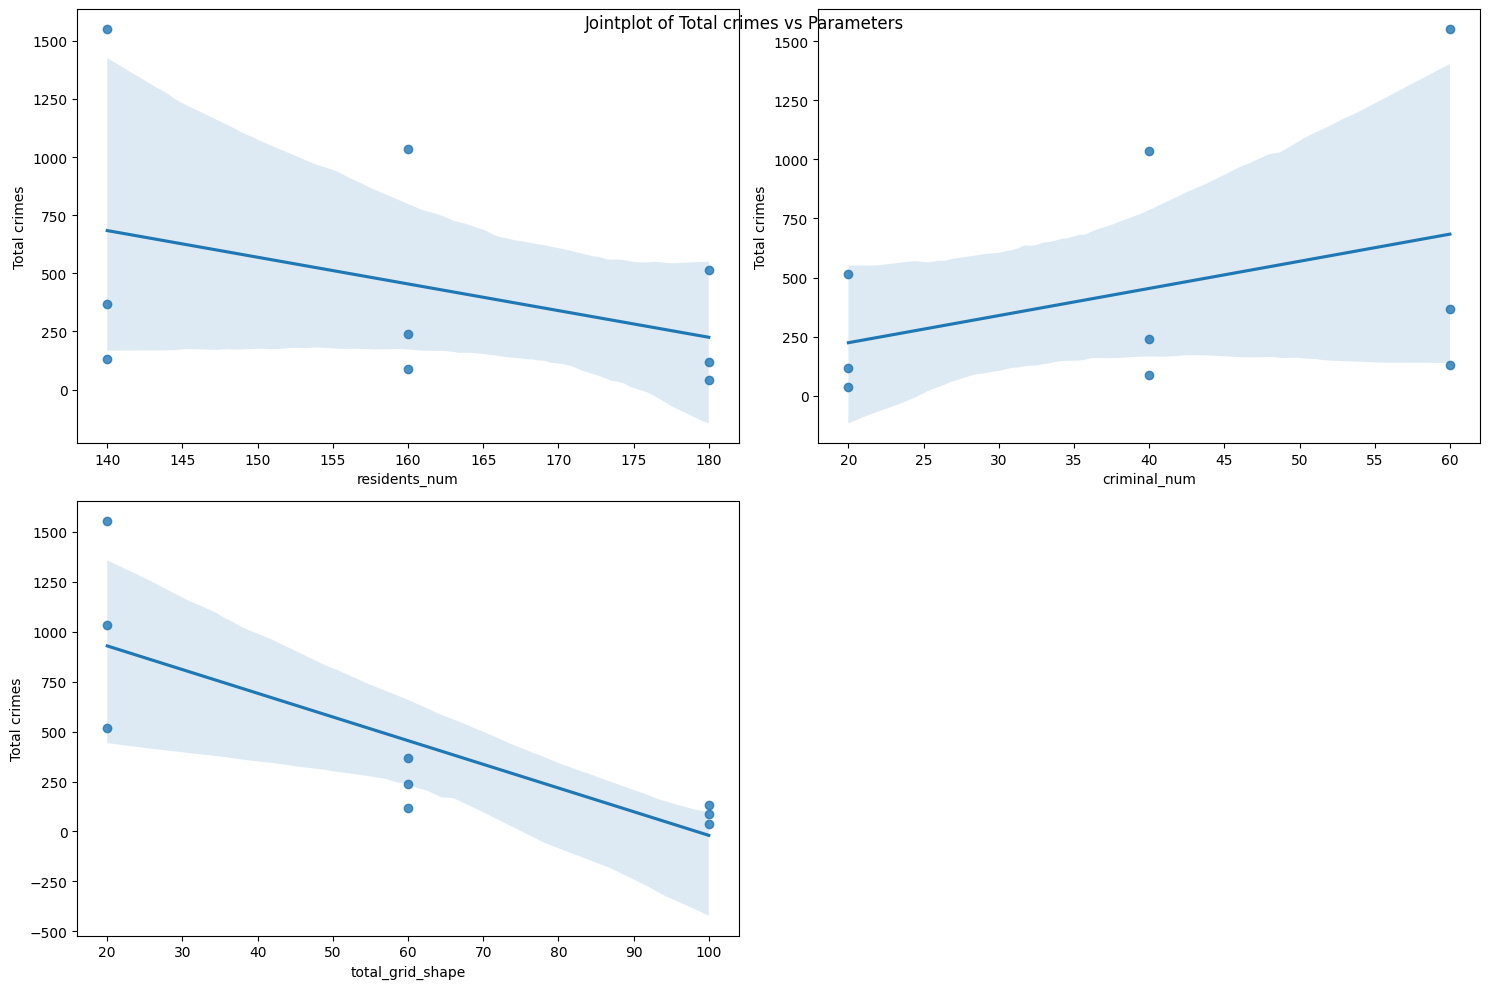

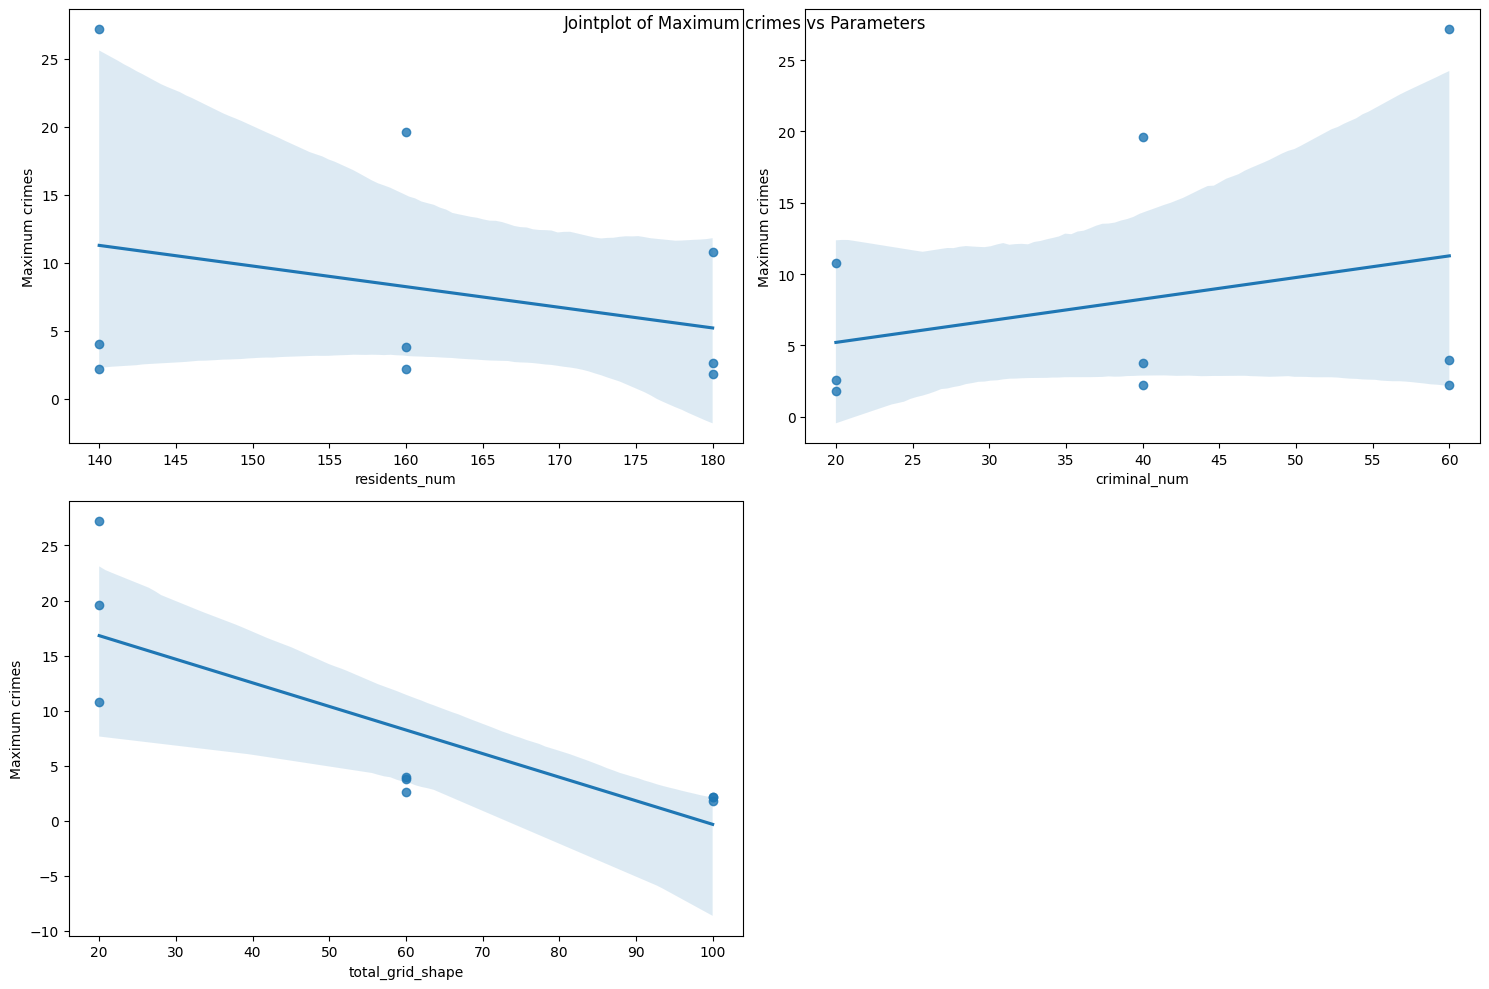

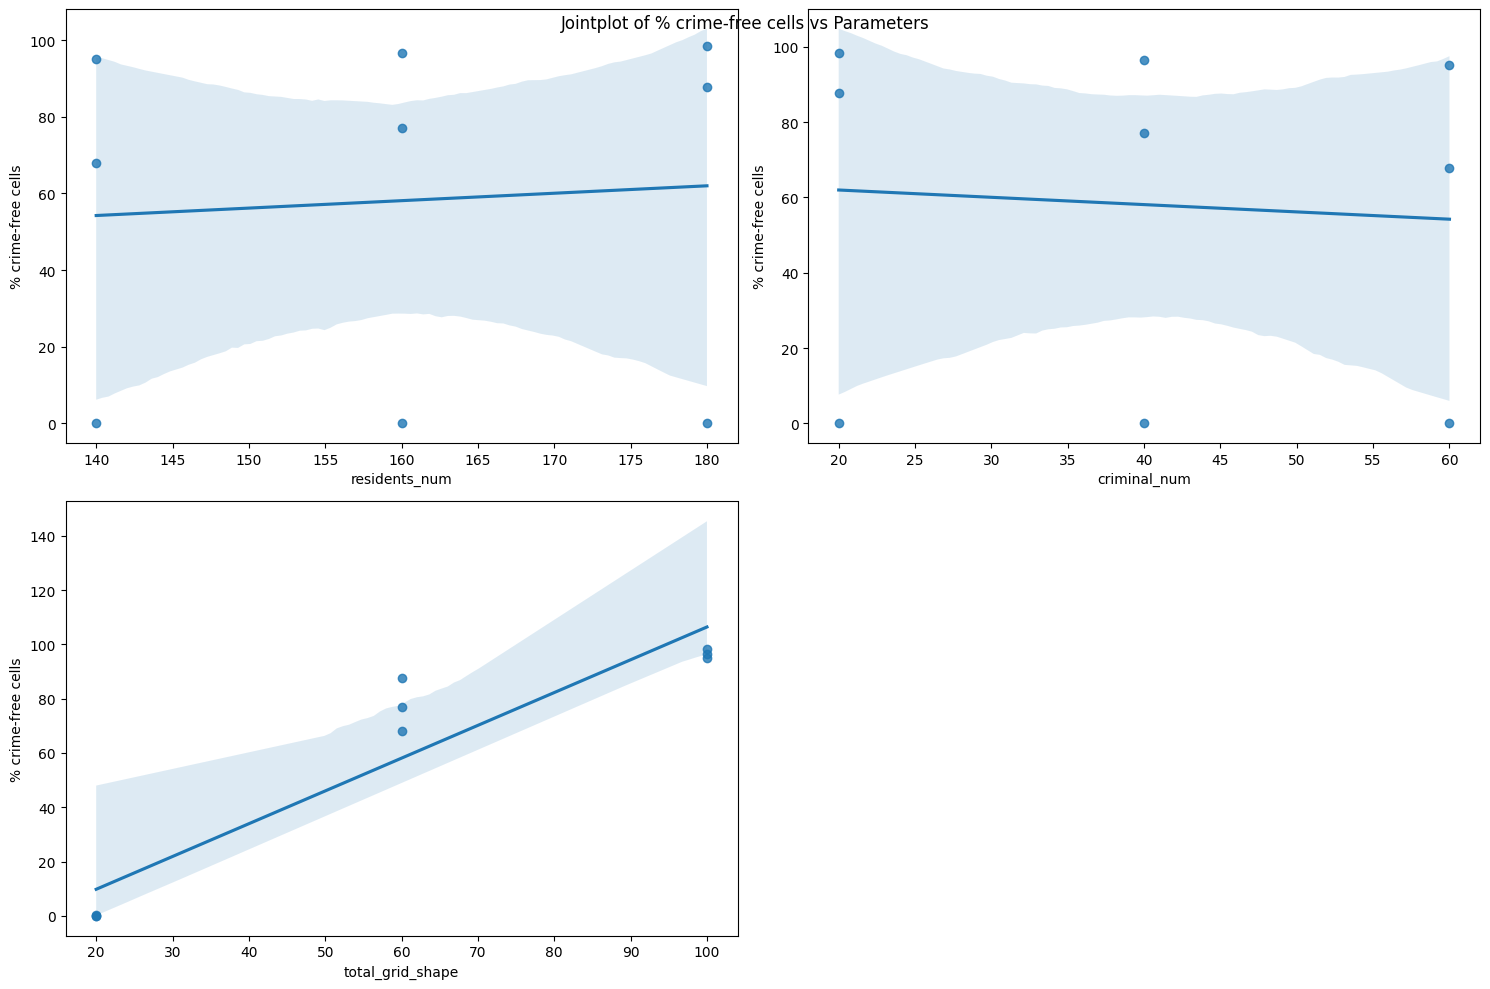

In [13]:
# Creates jointplots
for output_var in outcome_vars:
    plt.figure(figsize=(15, 10))
    for i, param in enumerate(input_params):
        plt.subplot(2, 2, i+1)
        sns.regplot(x=param, y=output_var, data=effects)
        plt.xlabel(param)
        plt.ylabel(output_var)
    plt.tight_layout()
    plt.suptitle(f'Jointplot of {output_var} vs Parameters')
    plt.show()


In [14]:
# Perform regression analysis
for output_var in outcome_vars:
    for param in input_params:
        # Perform linear regression
        slope, intercept, r_value, p_value, std_err = linregress(effects[param], effects[output_var])
        
        # Print regression results
        print(f"{output_var} vs {param}: R-squared = {r_value**2:.2f}, p-value = {p_value:.4f}")


Total crimes vs residents_num: R-squared = 0.15, p-value = 0.3050
Total crimes vs criminal_num: R-squared = 0.15, p-value = 0.3050
Total crimes vs total_grid_shape: R-squared = 0.64, p-value = 0.0101
Maximum crimes vs residents_num: R-squared = 0.08, p-value = 0.4571
Maximum crimes vs criminal_num: R-squared = 0.08, p-value = 0.4571
Maximum crimes vs total_grid_shape: R-squared = 0.65, p-value = 0.0088
% crime-free cells vs residents_num: R-squared = 0.01, p-value = 0.8473
% crime-free cells vs criminal_num: R-squared = 0.01, p-value = 0.8473
% crime-free cells vs total_grid_shape: R-squared = 0.88, p-value = 0.0002


# Part B

In [16]:
class Cell:
    def __init__(self, x, y): # inputs - coordinates
        self.x = x
        self.y = y
        
        self.agents = [] # stores agents located within the cell
        self.crimes = 0 # tracks the number of crimes committed in the cell


class Agent:
    def __init__(self, a_type, cell, budget, weight):
        '''inputs:
            a_type (str): type of agent - resident/criminal,
            cell (Cell object): cell in which the agent starts the simulation
            budget (int): resources at the disposal of the agent
            '''
        self.a_type = a_type
        self.cell = cell
        self.budget = budget
        self.weight = weight
        
        cell.agents.append(self) # locate agent inside the cell
    
    def distance(self, cell):
        '''Computes the distance between the agent's current location and a given cell.
        Inputs: cell - Cell object'''
        dx = self.cell.x - cell.x
        dy = self.cell.y - cell.y
        return (dx**2 + dy**2)**0.5
    
    def resident_step(self):
        '''step method for resident agents - moves to a random new cell'''
        self.budget += 1 # resources increase with every step
        new_cell = self.cell # set current cell as new cell
        while new_cell == self.cell: # loop to make sure a new cell is selected
            new_cell = choice(choice(model.grid)) # randomly choose an array and a cell from the array
        return new_cell
        
    def criminal_utility(self, cell, max_agents):
        '''Computes the utility the agent derives from the input cell, 
        based on distance and number of agents in the cell.
        Inputs: cell (Cell object) - the cell for which to compute utility, 
        max_agents (int) - the maximal number of agents present in one cell (required for normalization)'''
        if self.distance(cell) > self.budget:
            return 0
        else: 
            d_utility = 1-self.distance(cell)/self.budget
            c_utility = len(cell.agents)/max_agents
            utility = self.weight*c_utility + (1-self.weight)*d_utility

            return utility
    
    def criminal_step(self):
        '''step method for criminal agents - 
        move to a random cell based on probabilities, randomly select an agent and steal 1 resource point'''
        cells = [model.grid[x][y] for x in range(model.grid_shape[0]) for y in range(model.grid_shape[1]) 
                 if model.grid[x][y] != self.cell] # list all cells but current cell
        max_agents = max([len(c.agents) for c in cells]) # find the maximal number of agents per cell
        utilities = [self.criminal_utility(cell, max_agents) for cell in cells] # compute utility value per cell
        if sum(utilities) > 0: # choices requires that sum of weights would be greater than 0
            new_cell = choices(cells, utilities)[0] # randomly (with weights based on probabilities) choose one cell
        else:
            new_cell = choice(cells) # if sum of weights is zero, choose randmoly without weights
            
        if new_cell.agents: # if there are any agents in the cell (empty list==False)
            agent = choice(new_cell.agents) # randomly choose an agent present in the cell
            if agent.budget > 0: # if the agent has any resources - steal one unit
                agent.budget -= 1 # remove one unit of resources from selected agent
                self.budget += 1 # add one unit to current agent
                new_cell.crimes += 1 # increase the new cell's crime counter
    
        return new_cell
    
    def step(self):
        '''General step method for both types of agents:
            locates new cell and makes the required changes'''
        if self.a_type == 'resident': # check agent type and activate step method
            new_cell = self.resident_step()
        else:
            new_cell = self.criminal_step()
        
        self.cell.agents.remove(self) # remove current agent from current cell
        new_cell.agents.append(self) # add current agent to new cell
        self.cell = new_cell # move current agent to new cell
        

class Model:
    def __init__(self, residents_num, criminal_num, grid_shape, weight):
        '''inputs: residents_num (int) - number of resident agents,
        criminal_num (int) - number of criminal agents,
        grid_shape (container of two int items) - number of grid rows and columns,
        weight - weight parameter of crime factor in utility function'''
        self.grid_shape = grid_shape
        # add weight as requested
        self.weight = weight
        # create a 2D array of Cell objects
        self.grid = [[Cell(x, y) for y in range(grid_shape[1])] for x in range(grid_shape[0])] 
        # create a 1d Array of Agent objects  (length==resident_num) located in a random cell and with a random budget
        self.residents = [Agent('resident', choice(choice(self.grid)), randint(10, 50), self.weight) for i in range(residents_num)]
        # create a 1d Array of Agent objects  (length==criminal_num) located in a random cell and with budget==1
        self.criminals = [Agent('criminal', choice(choice(self.grid)), 1, self.weight) for i in range(criminal_num)]
        
        
    def simulate(self):
        '''Run 30 iterations and return the total number of crimes, maximal number of crimes per cell,
        and percent of cells where no crimes were registered througout the simulation'''
        for i in range(30):
            agents = self.residents + self.criminals # merge the lists of agents into one
            shuffle(agents) # randomly reorder the merged list
            for agent in agents: # execute step function per agent
                agent.step()
        
        # generate outputs - get the count of crimes per cell
        crimes = [self.grid[x][y].crimes for x in range(self.grid_shape[0]) for y in range(self.grid_shape[1])]
        total_crimes = sum(crimes) # total number of crimes committed throughout the simulation
        max_crimes = max(crimes) # get the counter value for the cell with the most crimes committed
        # compute the percent of cells where no crime was committed
        no_crimes = 100 * len([c for c in crimes if c==0]) / (self.grid_shape[0] * self.grid_shape[1])
        return (total_crimes, max_crimes, no_crimes)
        

model = Model(180, 20, (30, 30),0.5)
model.simulate()

(236, 3, 77.44444444444444)

In [17]:
params = pd.read_csv("parameters_B.csv")
print(params)

   residents_num  criminal_num  grid_shape1  grid_shape2  weight
0            180            20           30           30    0.25
1            180            20           30           30    0.50
2            180            20           30           30    0.75
3            160            40           30           30    0.25
4            160            40           30           30    0.50
5            160            40           30           30    0.75
6            140            60           30           30    0.25
7            140            60           30           30    0.50
8            140            60           30           30    0.75


In [18]:
outputs_avg = pd.DataFrame(columns = {
    'Total crimes':[],
    'Maximum crimes':[],
    '% crime-free cells':[]
})


# iterates through the parameters
for n, row in params.iterrows():
    total = []
    maximum = []
    percent = []
    # runs the simulation 5 times for each sets of parameters
    # saves averages of the 5 outputs
    for r in range(5):
        model = Model(int(row[0]), int(row[1]),(int(row[2]), int(row[3])), row[4])
        results = model.simulate()
        total.append(results[0])
        maximum.append(results[1])
        percent.append(results[2])
    outputs_avg.loc[len(outputs_avg)] = [np.mean(total),np.mean(maximum),np.mean(percent)]

effects = pd.concat([params, outputs_avg], axis=1)




In [19]:
effects = pd.concat([params, outputs_avg], axis=1)

# Remove extra space from column names
effects.columns = effects.columns.str.strip()

# Combine the two grid_shape columns into a new column
effects['total_grid_shape'] = effects['grid_shape1'] + effects['grid_shape2']

# drop old grid shape columns 
effects.drop(columns=['grid_shape1', 'grid_shape2'], inplace=True)

print(effects)
# saves output for table in writeup
effects.to_csv('effects_B_new.csv')

   residents_num  criminal_num  weight  Total crimes  Maximum crimes  \
0            180            20    0.25         163.0             3.2   
1            180            20    0.50         210.0             3.4   
2            180            20    0.75         297.8             4.4   
3            160            40    0.25         337.0             4.6   
4            160            40    0.50         428.6             5.6   
5            160            40    0.75         591.4             7.0   
6            140            60    0.25         504.4             5.6   
7            140            60    0.50         618.0             6.0   
8            140            60    0.75         853.4             8.8   

   % crime-free cells  total_grid_shape  
0           84.488889                60  
1           80.533333                60  
2           74.088889                60  
3           71.422222                60  
4           65.911111                60  
5           57.444444      

## EDA and Statistical Testing For Part B

In [21]:
# Define the input parameters and outcome variables
input_params = ['residents_num', 'criminal_num', 'weight']
outcome_vars = ['Total crimes', 'Maximum crimes', '% crime-free cells']

# Print the first few rows of the DataFrame
print(effects.head())


   residents_num  criminal_num  weight  Total crimes  Maximum crimes  \
0            180            20    0.25         163.0             3.2   
1            180            20    0.50         210.0             3.4   
2            180            20    0.75         297.8             4.4   
3            160            40    0.25         337.0             4.6   
4            160            40    0.50         428.6             5.6   

   % crime-free cells  total_grid_shape  
0           84.488889                60  
1           80.533333                60  
2           74.088889                60  
3           71.422222                60  
4           65.911111                60  


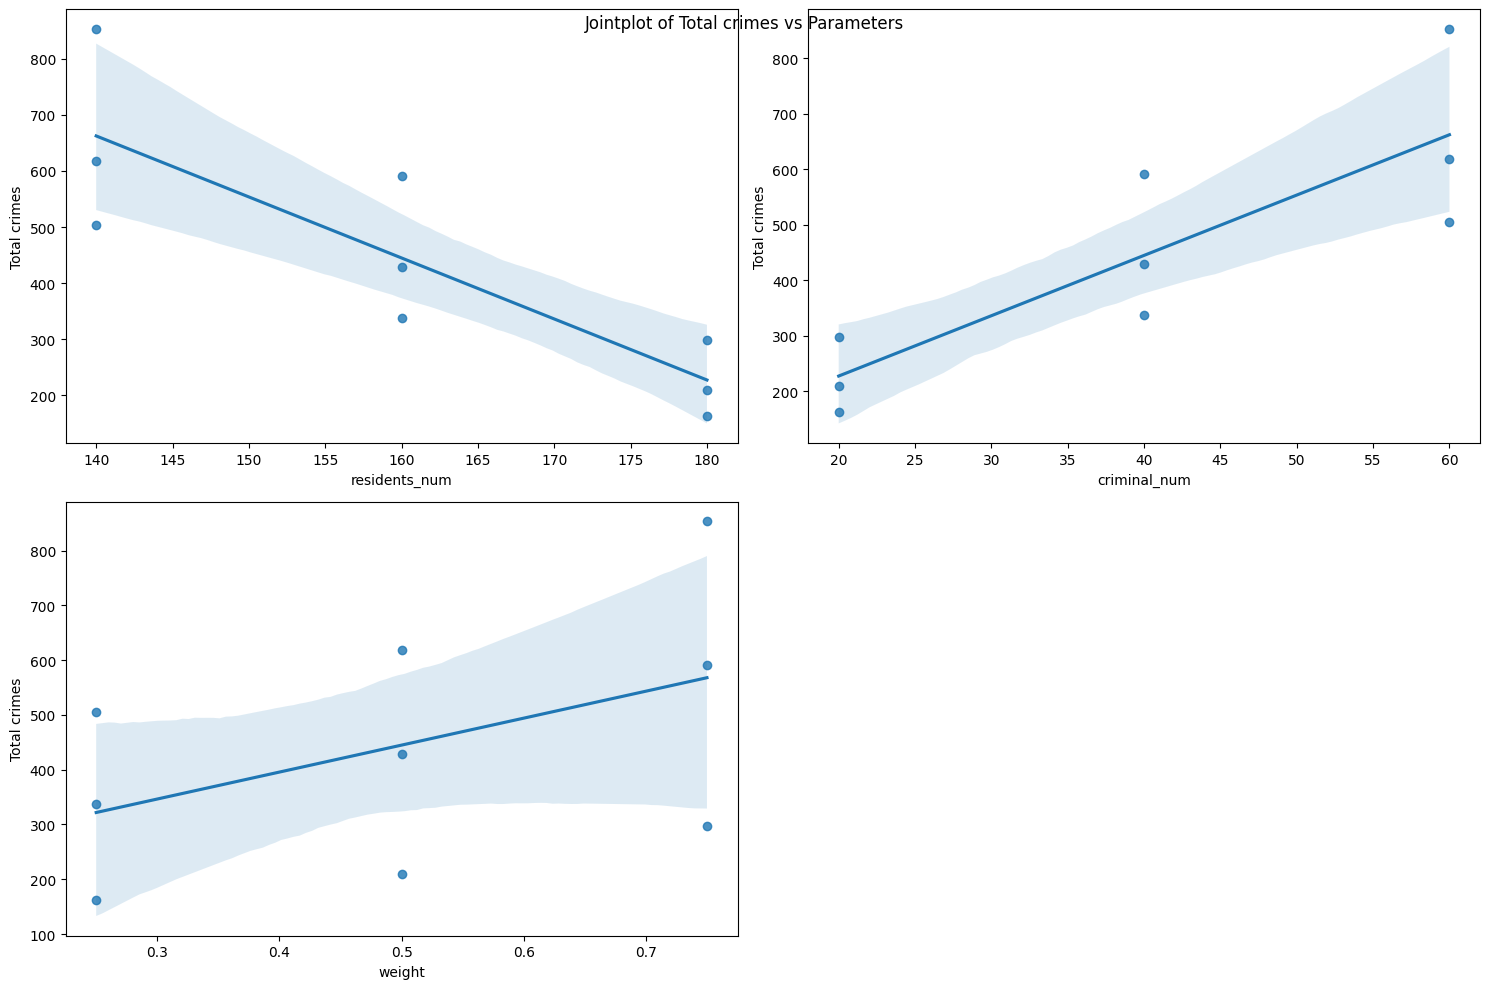

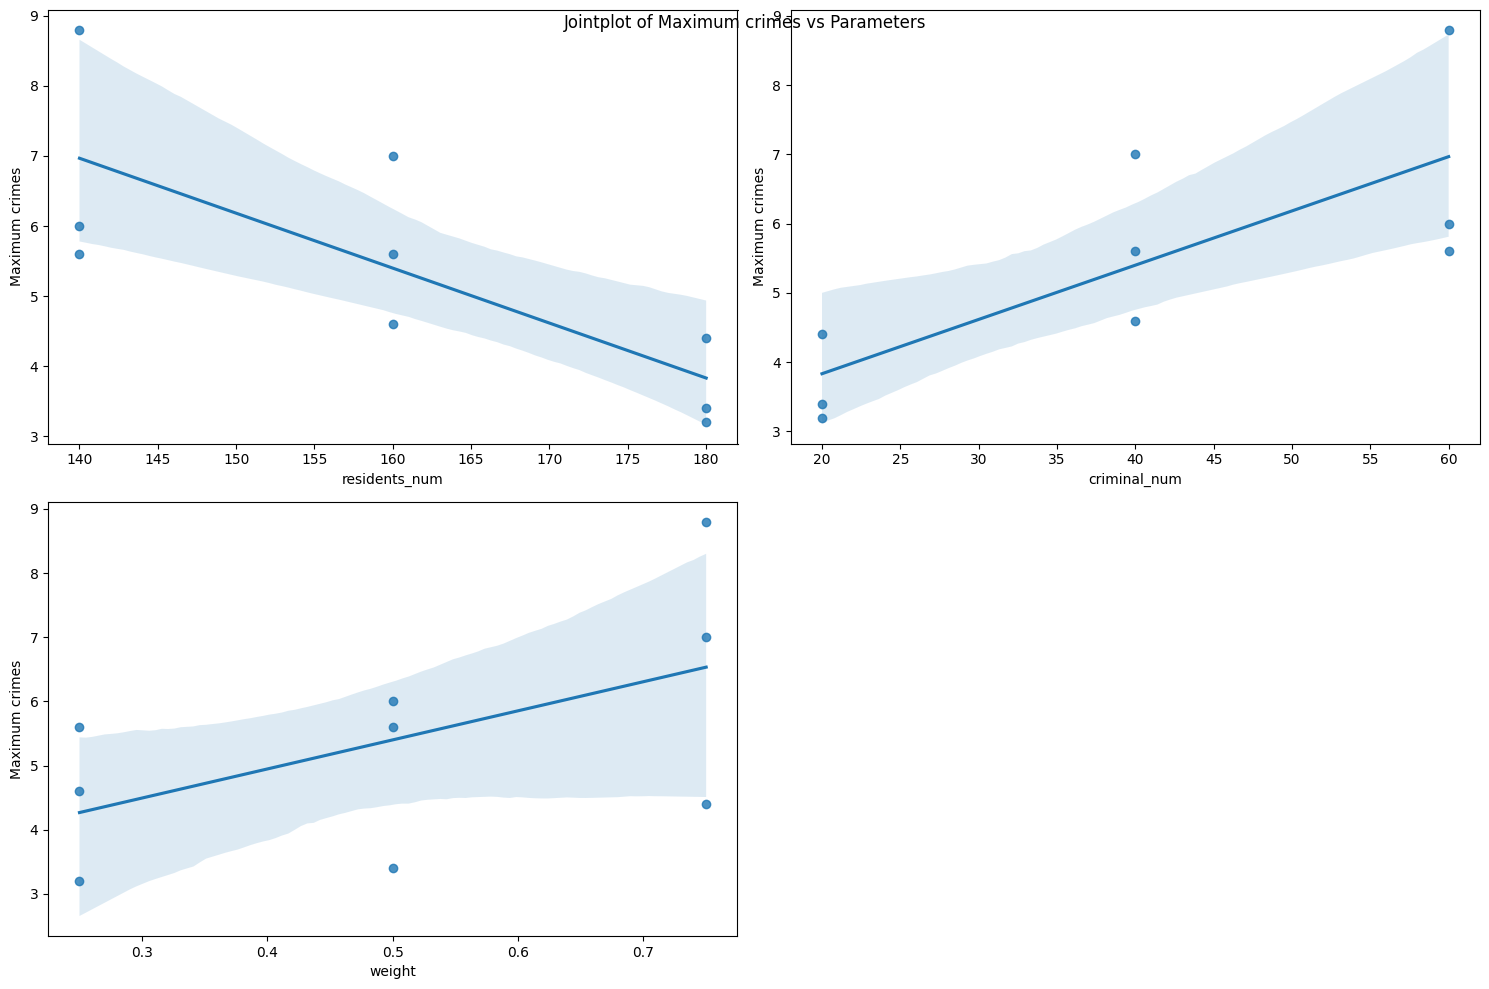

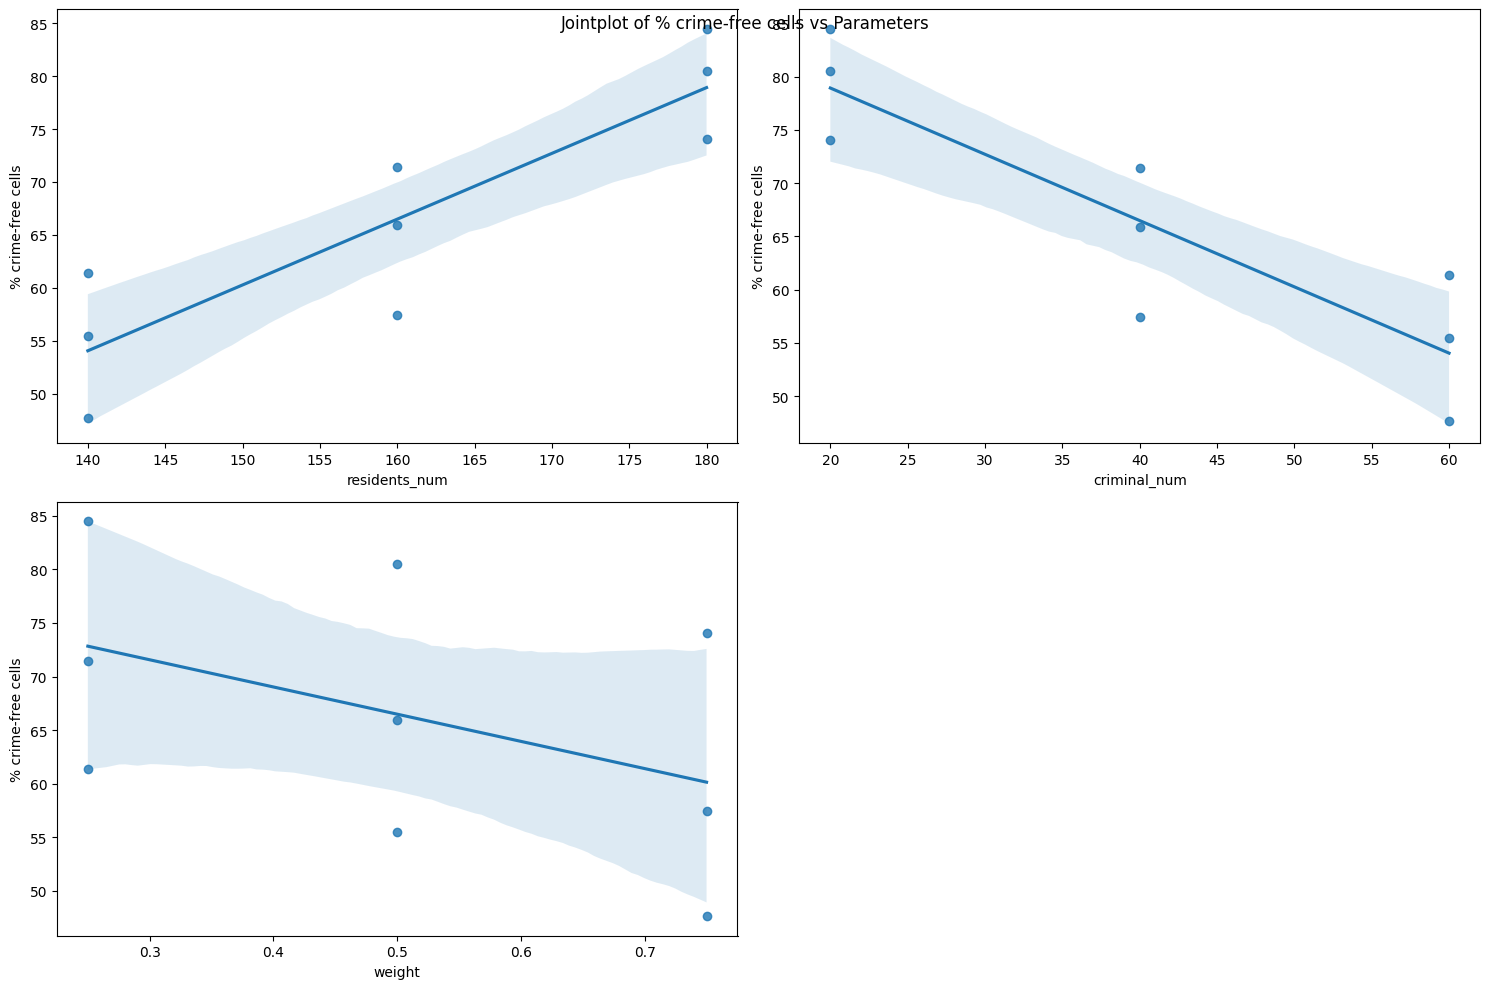

In [22]:
# Jointplot with Grid
for output_var in outcome_vars:
    plt.figure(figsize=(15, 10))
    for i, param in enumerate(input_params):
        plt.subplot(2, 2, i+1)
        sns.regplot(x=param, y=output_var, data=effects)
        plt.xlabel(param)
        plt.ylabel(output_var)
    plt.tight_layout()
    plt.suptitle(f'Jointplot of {output_var} vs Parameters')
    plt.show()


In [23]:
# Perform regression analysis
for output_var in outcome_vars:
    for param in input_params:
        # Perform linear regression
        slope, intercept, r_value, p_value, std_err = linregress(effects[param], effects[output_var])
        
        # Print regression results
        print(f"{output_var} vs {param}: R-squared = {r_value**2:.2f}, p-value = {p_value:.4f}")


Total crimes vs residents_num: R-squared = 0.73, p-value = 0.0035
Total crimes vs criminal_num: R-squared = 0.73, p-value = 0.0035
Total crimes vs weight: R-squared = 0.23, p-value = 0.1883
Maximum crimes vs residents_num: R-squared = 0.59, p-value = 0.0159
Maximum crimes vs criminal_num: R-squared = 0.59, p-value = 0.0159
Maximum crimes vs weight: R-squared = 0.31, p-value = 0.1211
% crime-free cells vs residents_num: R-squared = 0.78, p-value = 0.0016
% crime-free cells vs criminal_num: R-squared = 0.78, p-value = 0.0016
% crime-free cells vs weight: R-squared = 0.20, p-value = 0.2230


In [43]:
print(effects.corr())

                    residents_num  criminal_num    weight  Total crimes  \
residents_num            1.000000     -1.000000  0.000000     -0.853072   
criminal_num            -1.000000      1.000000  0.000000      0.853072   
weight                   0.000000      0.000000  1.000000      0.482558   
Total crimes            -0.853072      0.853072  0.482558      1.000000   
Maximum crimes          -0.766894      0.766894  0.554774      0.978907   
% crime-free cells       0.883964     -0.883964 -0.451061     -0.987032   
total_grid_shape              NaN           NaN       NaN           NaN   

                    Maximum crimes  % crime-free cells  total_grid_shape  
residents_num            -0.766894            0.883964               NaN  
criminal_num              0.766894           -0.883964               NaN  
weight                    0.554774           -0.451061               NaN  
Total crimes              0.978907           -0.987032               NaN  
Maximum crimes          